In [1]:
import persistence
import pandas as pd
from core import PositionState
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(24)

In [2]:
def load_data(experiment_dir: str, logger: str) -> list[dict]:
    data: list[dict] = []
    for log_file in persistence.list_files(experiment_dir, logger):
        data.append(persistence.load(experiment_dir, logger, log_file))
    return data

## PositionLogger

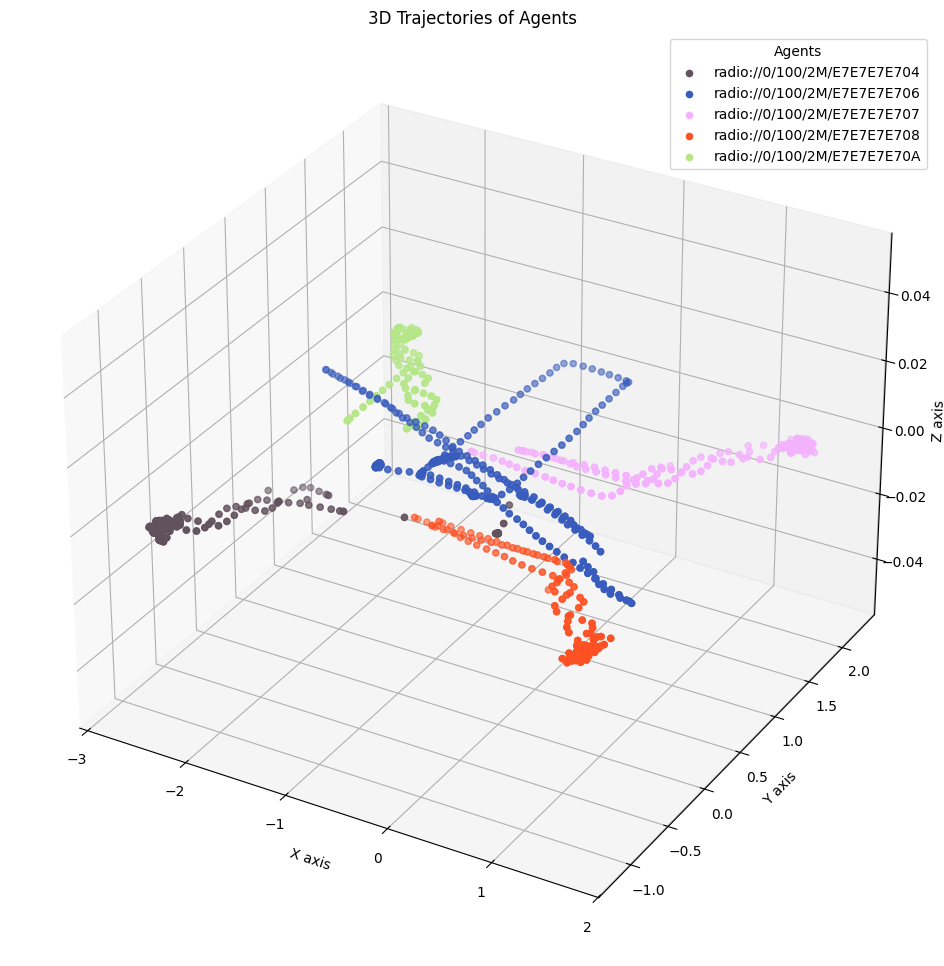

In [3]:
from numpy import ndarray


def plot_3d_trajectories(df: pd.DataFrame):
    assert set(df.columns) == {'agent', 'X', 'Y', 'Z'}, "Invalid df provided"

    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(111, projection='3d')

    unique_agents: list[str] = df['agent'].unique()
    colors: dict[str, ndarray] = {agent: np.random.rand(3,) for agent in sorted(unique_agents, key=lambda x: unique_agents.tolist().index(x))}

    for agent, group in df.groupby('agent'):
        ax.scatter(group['X'], group['Y'], group['Z'], color=colors[agent], label=agent)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Trajectories of Agents')
    ax.legend(title='Agents')

    plt.show()


processed_data: list[dict] = []
for data_log in load_data('default_vu', 'PositionLogger'):
    state: PositionState = data_log['state']
    processed_data.append(
        {
            'agent': data_log['agent'],
            'X' : state.position.x,
            'Y' : state.position.y,
            'z' : state.position.z,
        }
    )

df: pd.DataFrame = pd.DataFrame(processed_data, columns=['agent', 'X', 'Y', 'Z']).fillna(0)
plot_3d_trajectories(df)

## Field modulation

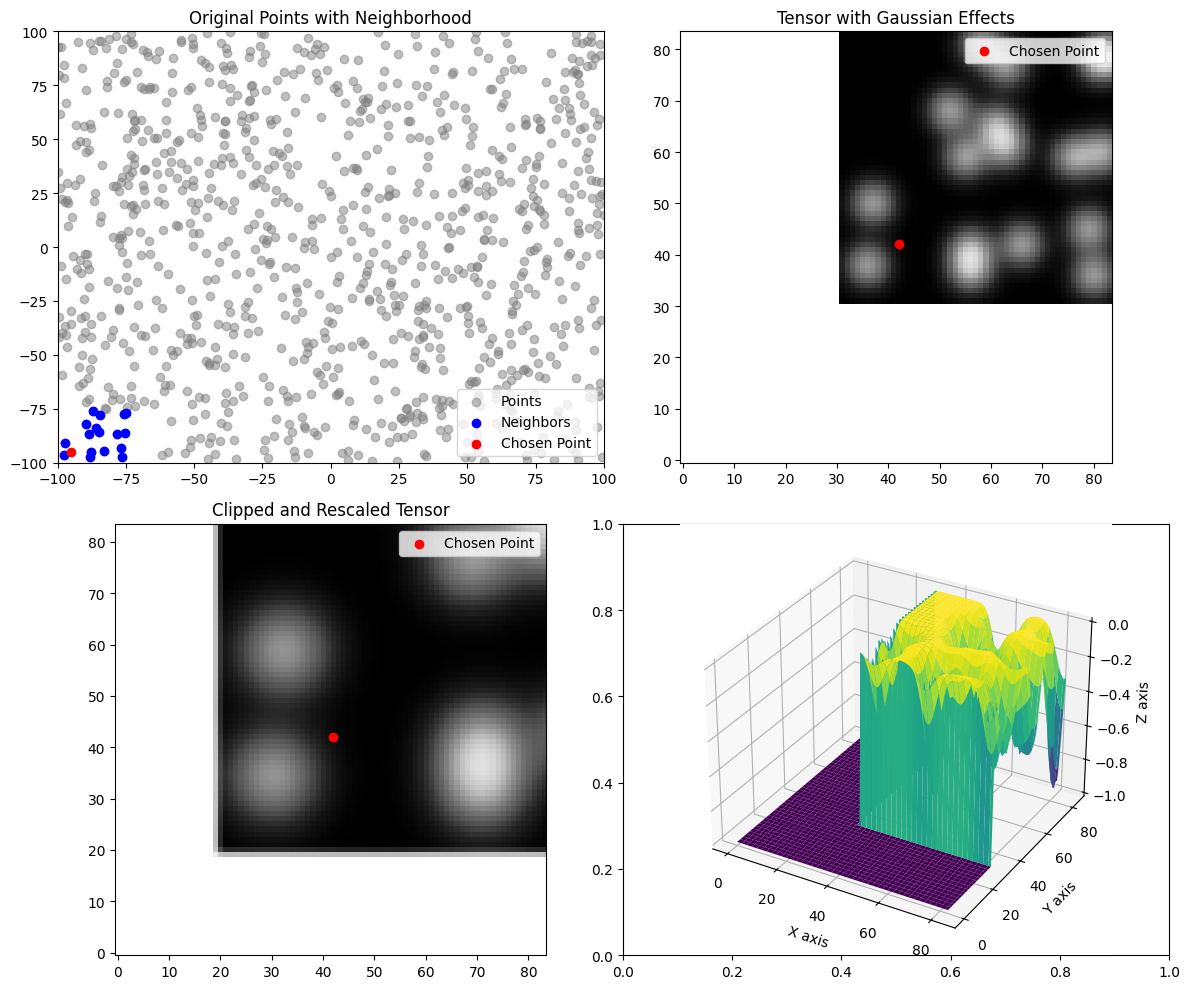

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from mpl_toolkits.mplot3d import Axes3D

# Parameters
vicinity_limit = [20, 20]  # The vicinity limit around the chosen point (x, y)
tensor_size = [84, 84]     # The size of the final tensor (height, width)
sigma_scale = 3            # Scale for the Gaussian sigma relative to the initial space unit
negative_value = -1      # Value to fill the tensor edges

# Step 1: Generate random points
num_points = 1000
points = np.random.uniform(-100, 100, size=(num_points, 2))

# Step 2: Choose a random center point
center_point = [-95, -95]

# Step 3: Find neighboring points within the box limit of ±vicinity_limit
x_min, x_max = center_point[0] - vicinity_limit[0], center_point[0] + vicinity_limit[0]
y_min, y_max = center_point[1] - vicinity_limit[1], center_point[1] + vicinity_limit[1]

neighbors = points[
    (points[:, 0] >= x_min) & (points[:, 0] <= x_max) &
    (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
]

INITIAL_VALUE_TENSOR = 0
# Step 4: Project the points onto a centered torch.Tensor of shape (tensor_size[0], tensor_size[1])
tensor = torch.full((tensor_size[0], tensor_size[1]), INITIAL_VALUE_TENSOR, dtype=torch.float32)

# Normalize points to the centered tensor space
def to_tensor_space(point, center_point, tensor_size, vicinity_limit):
    x, y = point
    cx, cy = center_point
    # Normalize to [0, 1] range first
    x_normalized = (x - (cx - vicinity_limit[0])) / (2 * vicinity_limit[0])
    y_normalized = (y - (cy - vicinity_limit[1])) / (2 * vicinity_limit[1])
    # Convert to tensor space indices
    x_tensor = int(round(x_normalized * (tensor_size[1] - 1)))
    y_tensor = int(round(y_normalized * (tensor_size[0] - 1)))
    # Clamp indices to ensure they are within bounds
    x_tensor = np.clip(x_tensor, 0, tensor_size[1] - 1)
    y_tensor = np.clip(y_tensor, 0, tensor_size[0] - 1)
    return x_tensor, y_tensor

# Apply Gaussian distribution around each neighboring point on the tensor
def apply_distribution(field, position, sigma=10, amplitude=0.2, operation='add'):
    x, y = position
    grid_x, grid_y = np.meshgrid(
        np.arange(field.shape[1]), np.arange(field.shape[0]), indexing="ij"
    )
    gaussian = amplitude * np.exp(
        -((grid_x - x) ** 2 + (grid_y - y) ** 2) / (2 * sigma ** 2)
    )

    if operation == 'add':
        return field + torch.tensor(gaussian, dtype=torch.float32)
    elif operation == 'subtract':
        return field - torch.tensor(gaussian, dtype=torch.float32)
    elif operation == 'replace':
        mask = gaussian > 0
        field[mask] = torch.tensor(gaussian[mask], dtype=torch.float32)
        return field
    else:
        raise ValueError("Invalid operation type. Use 'add', 'subtract', or 'replace'.")

# Apply Gaussian to each neighboring point, excluding the center point
for point in neighbors:
    if np.all(point == center_point):
        continue
    
    x_tensor, y_tensor = to_tensor_space(point, center_point, tensor_size, vicinity_limit)
    
    # Ensure the indices are within the bounds of the tensor
    if 0 <= x_tensor < tensor_size[1] and 0 <= y_tensor < tensor_size[0]:
        tensor = apply_distribution(tensor, (y_tensor, x_tensor), sigma=sigma_scale, amplitude=0.5, operation='subtract')
    else:
        print(f"Point {point} projected to out-of-bounds tensor coordinates ({x_tensor}, {y_tensor})")

# Fill tensor with the constant value outside the computed limits
limits = {
    "x_min": to_tensor_space([-100, center_point[1]], center_point, tensor_size, vicinity_limit)[0],
    "x_max": to_tensor_space([100, center_point[1]], center_point, tensor_size, vicinity_limit)[0],
    "y_min": to_tensor_space([center_point[0], -100], center_point, tensor_size, vicinity_limit)[1],
    "y_max": to_tensor_space([center_point[0], 100], center_point, tensor_size, vicinity_limit)[1]
}

tensor[:, :limits["x_min"]] = negative_value
tensor[:, limits["x_max"]+1:] = negative_value
tensor[:limits["y_min"], :] = negative_value
tensor[limits["y_max"]+1:, :] = negative_value

# Clip and resize the tensor
clip_size = [tensor_size[0] // 2, tensor_size[1] // 2]
start_x = tensor_size[1] // 2 - clip_size[1] // 2
start_y = tensor_size[0] // 2 - clip_size[0] // 2

clipped_tensor = tensor[start_y:start_y+clip_size[0], start_x:start_x+clip_size[1]]
rescaled_tensor = torch.tensor(zoom(clipped_tensor.numpy(), (tensor_size[0] / clip_size[0], tensor_size[1] / clip_size[1]), order=1), dtype=torch.float32)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot the original points and the chosen point
ax[0, 0].scatter(points[:, 0], points[:, 1], color='gray', alpha=0.5, label='Points')
ax[0, 0].scatter(neighbors[:, 0], neighbors[:, 1], color='blue', label='Neighbors')
ax[0, 0].scatter(center_point[0], center_point[1], color='red', label='Chosen Point')
ax[0, 0].set_xlim(-100, 100)
ax[0, 0].set_ylim(-100, 100)
ax[0, 0].legend()
ax[0, 0].set_title('Original Points with Neighborhood')

# Plot the tensor with Gaussian effects
ax[0, 1].imshow(tensor.numpy(), cmap='Greys', origin='lower')
center_x, center_y = to_tensor_space(center_point, center_point, tensor_size, vicinity_limit)
ax[0, 1].scatter(center_x, center_y, color='red', label='Chosen Point')
ax[0, 1].set_title('Tensor with Gaussian Effects')
ax[0, 1].legend()

# Plot the clipped and rescaled tensor
ax[1, 0].imshow(rescaled_tensor.numpy(), cmap='Greys', origin='lower')
center_x_rescaled, center_y_rescaled = tensor_size[1] // 2, tensor_size[0] // 2
ax[1, 0].scatter(center_x_rescaled, center_y_rescaled, color='red', label='Chosen Point')
ax[1, 0].set_title('Clipped and Rescaled Tensor')
ax[1, 0].legend()

# Plot the 3D surface plot
ax_3d = fig.add_subplot(2, 2, 4, projection='3d')

# Generate x and y coordinates
x = np.arange(tensor_size[1])  # Columns
y = np.arange(tensor_size[0])  # Rows
x, y = np.meshgrid(x, y)

# Plot the surface
ax_3d.plot_surface(x, y, tensor.numpy(), cmap='viridis')

# Set labels
ax_3d.set_xlabel('X axis')
ax_3d.set_ylabel('Y axis')
ax_3d.set_zlabel('Z axis')

# Show the plots
plt.tight_layout()
plt.show()
